In [1]:
from hstrat import hstrat
from iterpop import iterpop as ip
from keyname import keyname as kn
from matplotlib import pyplot as plt
from natsort import natsorted
from nbmetalog import nbmetalog as nbm
import pandas as pd
import seaborn as sns
import sympy
from teeplot import teeplot as tp


In [2]:
nbm.print_metadata()


context: ci
hostname: 2a5b7f51d0e9
interpreter: 3.8.12 (default, Jan 15 2022, 18:39:47)  [GCC 7.5.0]
nbcellexec: 2
nbname: space_complexity
nbpath: /opt/hereditary-stratigraph-concept/binder/retention-policies/space_complexity.ipynb
revision: null
session: b91c1b48-5aad-45c1-a1a9-42adca65cb9d
timestamp: 2022-08-14T04:14:48Z00:00


IPython==7.16.1
keyname==0.4.1
yaml==5.3.1
hstrat==0.3.2
iterpop==0.4.0
matplotlib==3.3.2
nbmetalog==0.2.6
pandas==1.1.2
seaborn==0.11.0
sympy==1.5.1
teeplot==0.2.0
re==2.2.1
ipython_genutils==0.2.0
logging==0.5.1.2
zmq==22.3.0
json==2.0.9
ipykernel==5.5.3


# How many strata are retained under the recency-proportional resolution policy?


In [3]:
records = [{
    'Generations Elapsed': generations_elapsed,
    'Resolution': str(resolution),
    'Num Strata Retained': hstrat\
        .StratumRetentionPredicateRecencyProportionalResolution(resolution)\
        .CalcNumStrataRetainedExact(generations_elapsed),
}
    for generations_elapsed in (10**3, 10**6, 10**9, 10**12)
    for resolution in (1, 2, 4, 10, 100)
]
df = pd.DataFrame.from_records(records)
df


,Generations Elapsed,Resolution,Num Strata Retained
0,1000,1,18
1,1000,2,26
2,1000,4,41
3,1000,10,80
4,1000,100,428
5,1000000,1,32
6,1000000,2,50
7,1000000,4,85
8,1000000,10,184
9,1000000,100,1430


In [4]:
piv = pd.pivot(
    df,
    values=['Num Strata Retained'],
    index=['Generations Elapsed'],
    columns=['Resolution'],
)
# piv.columns = piv.columns.map(', Resolution '.join)
piv[piv.index.name] = piv.index
piv.reset_index(drop=True, inplace=True)
piv = piv.reindex(natsorted(piv.columns), axis=1)
# piv.columns.names = (None, None)
piv


Generations Elapsed Num Strata Retained                     
Resolution                                       1    2    4   10   100
0                         1000                  18   26   41   80   428
1                      1000000                  32   50   85  184  1430
2                   1000000000                  51   79  134  293  2435
3                1000000000000                  64  102  177  396  3437

In [5]:
piv.to_csv(kn.pack({
    'a': 'space-complexity',
    'policy': 'recency-proportional-resolution',
    'ext': '.csv',
}))


teeplots/hue=resolution+marker=o+policy=recency-proportional-resolution+viz=loglineplot+x=generations-elapsed+y=num-strata-retained+ext=.pdf
teeplots/hue=resolution+marker=o+policy=recency-proportional-resolution+viz=loglineplot+x=generations-elapsed+y=num-strata-retained+ext=.png


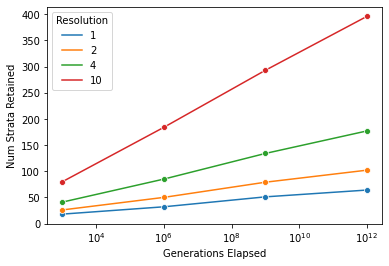

In [6]:
def loglineplot(*args, **kwargs):
    sns.lineplot(*args, **kwargs)
    plt.gca().set_xscale('log')

tp.tee(
    loglineplot,
    data=df[df['Resolution'].astype(int) < 100],
    x='Generations Elapsed',
    y='Num Strata Retained',
    hue='Resolution',
    marker='o',
    teeplot_outattrs={
        'policy': 'recency-proportional-resolution',
    },
)


# How does recency-proportional stratum retention scale with resolution?


From <https://github.com/mmore500/hstrat/blob/3eebabb6931b3ef3bbf6b7808a6e136caf600bd8/hstrat/hstrat/stratum_retention_predicates/StratumRetentionPredicateRecencyProportionalResolution.py#L222> we have space complexity of the recency-proportional resolution as less than or equal to

$\begin{align*}
\log(x) + \sum_{i=1}^r \log\Big(\frac{n}{i}\Big)
\end{align*}$

where $r$ is resolution parameter and $n$ is number of strata deposited.
(This is within a constant factor, glossing over $\log$ vs. $\log_2$, omitting integer truncated division, and substituting $\log(x)$ for integer bit weight.)

Applying logarithm properties,

$\begin{align*}
\sum_{i=1}^r \log\Big(\frac{n}{i}\Big)
&= \log\Big(\prod_{i=1}^r \frac{n}{i}\Big)\\
&= \log\Big(\frac{\prod_{i=1}^r n}{\prod_{i=1}^r i}\Big)\\
&= \log\Big(\frac{n^r}{r!}\Big).
\end{align*}$

So, we can re-express space complexity as

$\begin{align*}
\log(n) + \log\Big(\frac{n^r}{r!}\Big).
\end{align*}$

In order to understand how space complexity scales with respect to resolution $r$, we can consider the ratio of space complexity between a policy with resolution $r$ and a policy with twice the resolution $2r$ as $r$ goes to infinity.
Let's apply computer algebra to evaluate this limit.


In [7]:
# specify variables with assumptions for domain
r = sympy.Symbol('r', integer=True, positive=True, real=True,)
n = sympy.Symbol('n', integer=True, positive=True, real=True,)

space_complexity = sympy.log(n**r / sympy.factorial(r)) + sympy.log(n)
space_complexity


log(n) + log(n**r/factorial(r))

In [8]:
ratio = space_complexity.subs(r, 2*r) / space_complexity
ratio


(log(n) + log(n**(2*r)/factorial(2*r)))/(log(n) + log(n**r/factorial(r)))

Evaluating as $n \to \infty$,


In [9]:
lim = sympy.Limit(ratio, n, sympy.oo)
lim


Limit((log(n) + log(n**(2*r)/factorial(2*r)))/(log(n) + log(n**r/factorial(r))), n, oo, dir='-')

In [10]:
lim.doit().simplify()


(2*r + 1)/(r + 1)

Evaluating as $r \to \infty$,


In [11]:
lim = sympy.Limit(ratio, r, sympy.oo)
lim


Limit((log(n) + log(n**(2*r)/factorial(2*r)))/(log(n) + log(n**r/factorial(r))), r, oo, dir='-')

In [12]:
lim.doit()


2

## Result

Doubling resolution doubles space complexity.
So, in the limit, space complexity scales linearly with desired resolution.
